#### ---------------------------------------------------------------
# 📁 Portfolio Project: Predicting Activist Investor Targeting
# Author: YI LUO
# Date: 2025-04-15
# Source Dataset: https://www.kaggle.com/datasets/papaloveray/activist-target-prediction
# ---------------------------------------------------------------

# 🧠 Introduction:
# This portfolio project was developed as part of my job application for a role focused 
# on financial data analysis and activist investment research. The goal is to predict 
# which public companies are more likely to be targeted by activist investors based on 
# their financial and structural characteristics.

# The primary dataset, sourced from Kaggle, includes two main components:
# - `campaigns.csv`: historical records of over 3,000 activist campaigns from 2011 to 2023,
#   detailing activist groups, campaign outcomes, and financial returns.
# - `2016-2023.csv` and `median_original.csv`: firm-level financial metrics, valuation ratios, 
#   performance indicators, and market characteristics across thousands of companies.

# 🛠️ Workflow Summary:
# - Performed Exploratory Data Analysis (EDA) on activist campaign behavior and outcomes
# - Merged campaign data with company fundamentals using company names and years
# - Labeled companies as targeted (1) or not (0) based on campaign involvement
# - Selected 12 most meaningful financial features using Random Forest importance
# - Handled extreme class imbalance with SMOTE (synthetic oversampling)
# - Trained and evaluated multiple models: Random Forest, LightGBM, and a meta-model ensemble
# - Tuned classification thresholds to explore trade-offs between precision and recall

# 🎯 Key Findings:
# - Random Forest achieved 0.92 precision and high specificity but low recall
# - LightGBM improved ROC AUC to 0.675 and identified more true positives
# - A stacked meta-model offered a balanced performance with 44% precision and 14% recall
# - Most predictive features included CEO tenure, ROIC, free float %, sales growth, and volatility
# - Precision-Recall curves and threshold tuning provided actionable strategies for targeting

# 📌 Conclusion:
# This project demonstrates a complete machine learning pipeline for solving a highly imbalanced 
# binary classification task in the activist investment domain. It blends financial insight 
# with predictive modeling and offers practical tools to prioritize companies for activist analysis. 
# This work highlights my ability to translate complex datasets into decision-ready intelligence.

# ---------------------------------------------------------------


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the data
campaigns_path = "/Users/luoyi/Desktop/10_kaggle/14_activist/campaigns.csv"  # update path if needed
df_campaigns = pd.read_csv(campaigns_path)

# Clean column names (remove spaces)
df_campaigns.columns = df_campaigns.columns.str.strip().str.replace(" ", "_")

# Show basic info and first few rows
print("📌 Dataset shape:", df_campaigns.shape)
print("📌 Column names:", df_campaigns.columns.tolist())
df_campaigns.head()

📌 Dataset shape: (3369, 39)
📌 Column names: ['Flag', 'Company', 'Ticker', 'Unnamed:_3', 'Activist_Group', 'Start_Date', 'Hostility_End_Date', 'Start_Year', 'Start_Month', 'Start_Day', 'Stake_End_Date', 'Objectives', 'Hp_Return', 'Market_Cap_At_Start', 'Stake_At_Start', 'Start_Link', 'News_Search', 'Start_Date_And_Time', 'Current_Ticker', 'First_Affected_Date', 'Hostility_End_Date.1', 'End_Year', 'End_Month', 'End_Day', 'Sector', 'Industry_Name', 'Outcome', 'Region_Exchange', 'Country_Exchange', 'Country_Incorporation', 'State_Incorporation', 'Proxy_Fight_Boolean', 'Campaign_Status', 'Activist_Tier', 'Stake_Value_At_Start', 'One_Day_Return', 'One_Year_Return', 'Follower_Return', 'Annualized_Hp_Return']


,Flag,Company,Ticker,Unnamed:_3,Activist_Group,Start_Date,Hostility_End_Date,Start_Year,Start_Month,Start_Day,...,Country_Incorporation,State_Incorporation,Proxy_Fight_Boolean,Campaign_Status,Activist_Tier,Stake_Value_At_Start,One_Day_Return,One_Year_Return,Follower_Return,Annualized_Hp_Return
0,225134646,Peabody Energy Corp,PEABODY ENERGY,#N/A Invalid Security,Discovery Capital Management LLC/CT,23/12/2016 0:00,NaN,2011,1,6,...,UNITED STATES OF AMERICA,DE,No Proxy Fight,Closed - Activist Stake Sold,Occasional Activist,1.186886e+07,-27.211800,-94.86595,-59.48434,-70.509380
1,225134646,Performant Financial Corp,PERFORMANT FINANCIAL,#N/A Review,Philadelphia Financial Management of San Franc...,22/12/2016 0:00,NaN,2011,6,3,...,UNITED STATES OF AMERICA,DE,No Proxy Fight,Closed - Activist Stake Sold,Secondary Focus,7.794329e+06,5.660378,-22.64151,36.16071,31.192094
2,225134646,Fred's Inc,0354071D US,#N/A Field Not Applicable,Alden Global Capital LLC,22/12/2016 0:00,10/11/2018,2011,6,6,...,UNITED STATES OF AMERICA,TN,No Proxy Fight,Closed - Activist Stake Sold,Secondary Focus,1.798482e+08,4.231166,-78.88828,-99.96423,-89.583291
3,225134646,CPS Technologies Corp,CPS TECHNOLOGIES,#N/A Invalid Security,Horton Capital Partners LLC,22/12/2016 0:00,5/9/2017,2011,6,13,...,UNITED STATES OF AMERICA,DE,Proxy Fight,Closed - Activist Stake Sold,Secondary Focus,7.393920e+05,7.142857,19.28572,-13.33333,-7.142857
4,225134646,Brookdale Senior Living Inc,BKD US,BKD,Land & Buildings Investment Management LLC,20/12/2016 0:00,10/8/2019,2011,6,13,...,UNITED STATES OF AMERICA,DE,Proxy Fight,Closed - Activist Stake Sold,Core Activist,2.603362e+07,2.987421,-23.58491,-78.24428,-35.570822


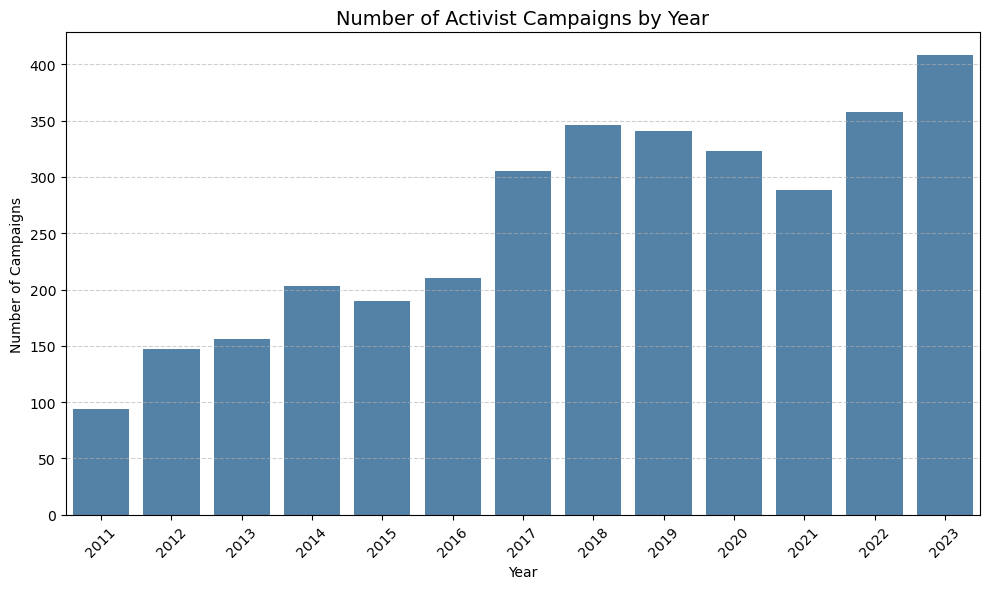

In [2]:
# Count campaigns per year
yearly_counts = df_campaigns['Start_Year'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=yearly_counts.index, y=yearly_counts.values, color='steelblue')
plt.title("Number of Activist Campaigns by Year", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Number of Campaigns")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


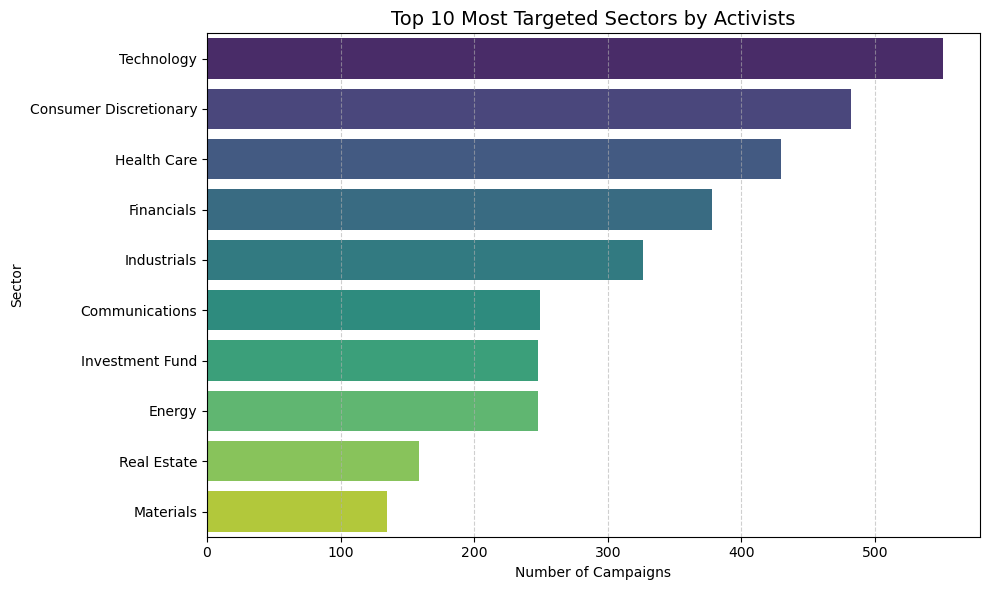

In [3]:
# Count campaigns by sector (remove missing values)
sector_counts = df_campaigns['Sector'].dropna().value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sector_counts.values, y=sector_counts.index, palette='viridis')
plt.title("Top 10 Most Targeted Sectors by Activists", fontsize=14)
plt.xlabel("Number of Campaigns")
plt.ylabel("Sector")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


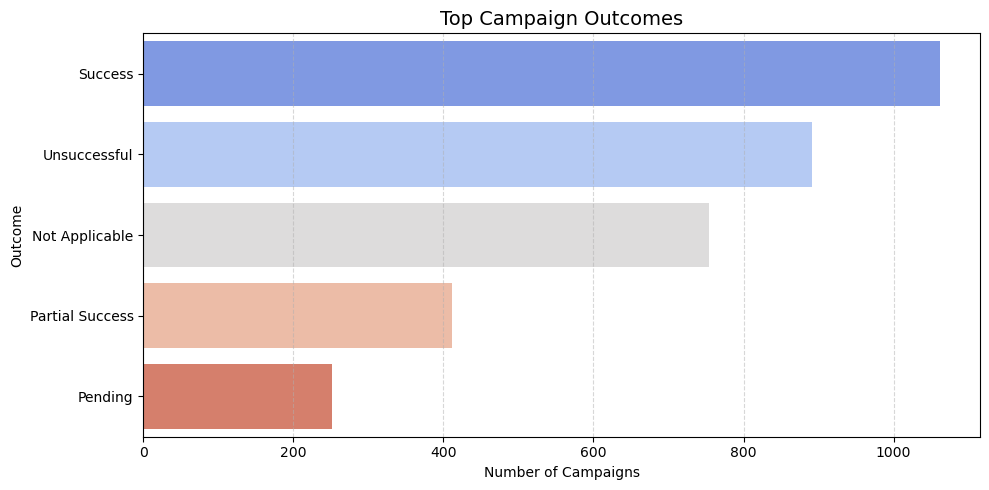

In [4]:
# Count campaign outcomes
outcome_counts = df_campaigns['Outcome'].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=outcome_counts.values, y=outcome_counts.index, palette='coolwarm')
plt.title("Top Campaign Outcomes", fontsize=14)
plt.xlabel("Number of Campaigns")
plt.ylabel("Outcome")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


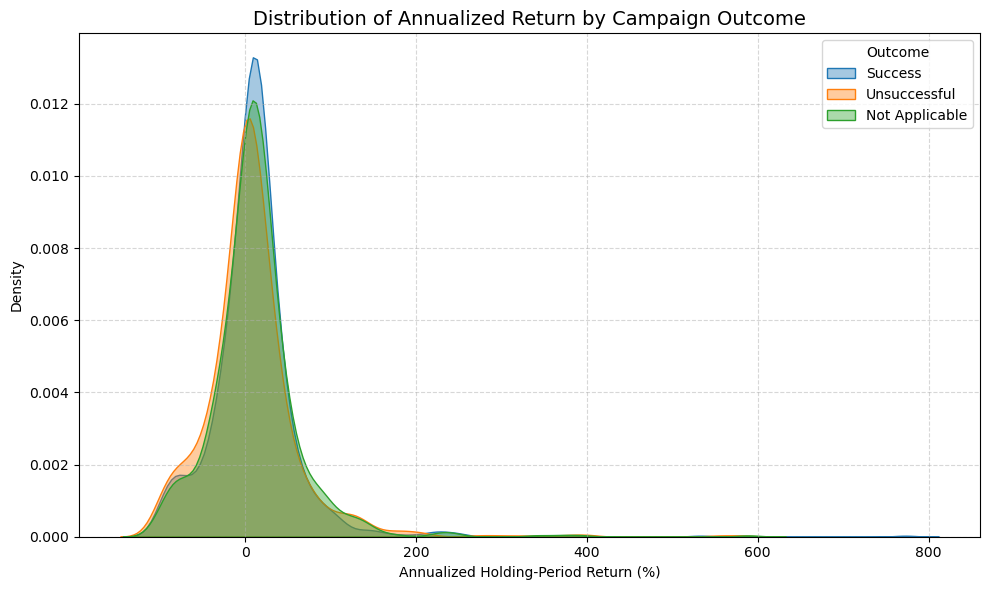

In [5]:
# Convert return columns to numeric (handle non-numeric cases safely)
df_campaigns['Annualized_Hp_Return'] = pd.to_numeric(df_campaigns['Annualized_Hp_Return'], errors='coerce')
df_campaigns['Outcome'] = df_campaigns['Outcome'].fillna('Unknown')

# Plot KDE of annualized returns by outcome top3 
top_outcomes = df_campaigns['Outcome'].value_counts().head(3).index
plt.figure(figsize=(10, 6))

for outcome in top_outcomes:
    subset = df_campaigns[df_campaigns['Outcome'] == outcome]
    sns.kdeplot(subset['Annualized_Hp_Return'], label=outcome, fill=True, alpha=0.4)

plt.title("Distribution of Annualized Return by Campaign Outcome", fontsize=14)
plt.xlabel("Annualized Holding-Period Return (%)")
plt.ylabel("Density")
plt.legend(title="Outcome")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


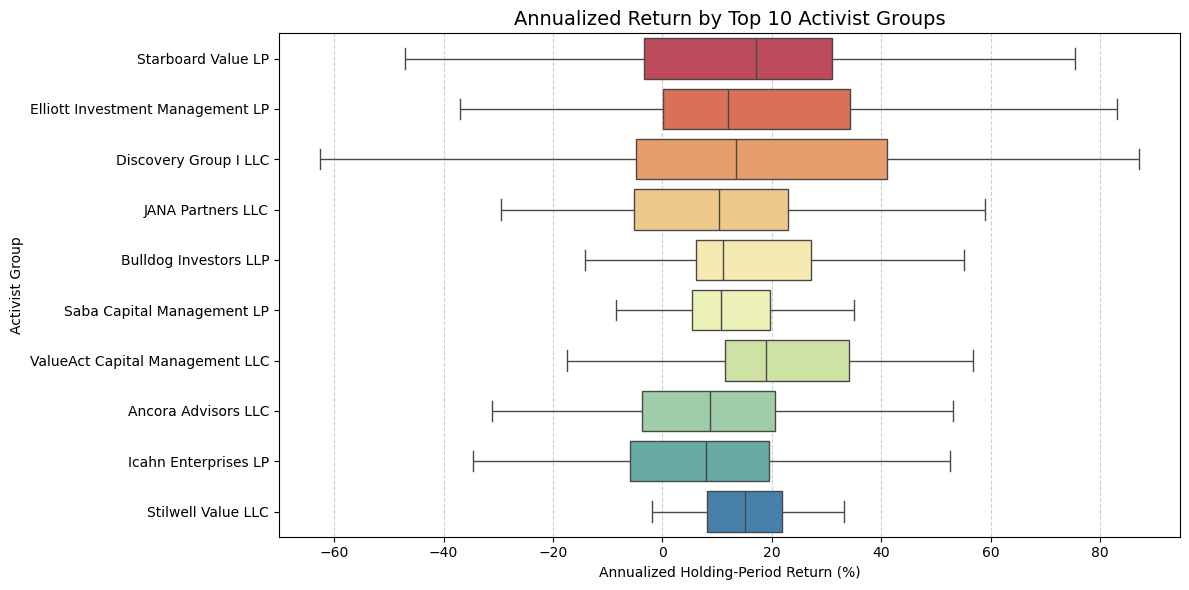

In [6]:
# Count campaigns by activist group (top 10)
top_activists = df_campaigns['Activist_Group'].value_counts().head(10).index

# Filter for top groups
df_top_activists = df_campaigns[df_campaigns['Activist_Group'].isin(top_activists)]

# Boxplot: Annualized return by activist group
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_activists,
            x='Annualized_Hp_Return',
            y='Activist_Group',
            orient='h',
            palette='Spectral',
            showfliers=False)
plt.title("Annualized Return by Top 10 Activist Groups", fontsize=14)
plt.xlabel("Annualized Holding-Period Return (%)")
plt.ylabel("Activist Group")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [7]:
#Load company-level data
df_companies = pd.read_csv("/Users/luoyi/Desktop/10_kaggle/14_activist/median_original.csv")

# Preview structure
print("✅ Data shape:", df_companies.shape)
print("🧩 First 10 columns:", df_companies.columns[:10].tolist())

# Show label distribution
print("🎯 Target label distribution:\n", df_companies['targeted'].value_counts())

print("🔍 Missing values before fill:\n", df_companies.isna().sum())
df_companies = df_companies.fillna(df_companies.median(numeric_only=True))
print("✅ Missing values after fill:\n", df_companies.isna().sum())

# Display first few rows
df_companies.head()

✅ Data shape: (22125, 130)
🧩 First 10 columns: ['Unnamed: 0.1', 'Unnamed: 0', 'year', 'ID', 'ticker', 'company_name', 'market_cap', 'bic_level_2', 'bic_level_3', 'unequal_voting']
🎯 Target label distribution:
 targeted
0    21380
1      745
Name: count, dtype: int64
🔍 Missing values before fill:
 Unnamed: 0.1        0
Unnamed: 0          0
year                0
ID                  0
ticker              0
                 ... 
year_2021           0
year_2022           0
year_2023           0
targeted            0
training_data    2711
Length: 130, dtype: int64
✅ Missing values after fill:
 Unnamed: 0.1     0
Unnamed: 0       0
year             0
ID               0
ticker           0
                ..
year_2021        0
year_2022        0
year_2023        0
targeted         0
training_data    0
Length: 130, dtype: int64


,Unnamed: 0.1,Unnamed: 0,year,ID,ticker,company_name,market_cap,bic_level_2,bic_level_3,unequal_voting,...,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,targeted,training_data
0,0,0,2016,1518855D US Equity,1518855D,Yahoo! Inc - Set up for Fundam,3.690000e+10,Media,Internet Media & Services,0.0,...,True,False,False,False,False,False,False,False,0,0.0
1,1,1,2016,1539941D UN Equity,1539941D,Spectra Energy LLC,2.880000e+10,Oil & Gas,Oil & Gas Producers,0.0,...,True,False,False,False,False,False,False,False,0,1.0
2,2,2,2016,1556442D UA Equity,1556442D,GigPeak Inc,1.710000e+08,Tech Hardware & Semiconductors,Semiconductors,0.0,...,True,False,False,False,False,False,False,False,0,1.0
3,3,4,2016,1624831D UN Equity,1624831D,TIAA FSB Holdings Inc,2.460000e+09,Banking,Banking,0.0,...,True,False,False,False,False,False,False,False,0,1.0
4,4,5,2016,1627503D UN Equity,1627503D,Colony Capital Inc/Old,2.310000e+09,Financial Services,Specialty Finance,1.0,...,True,False,False,False,False,False,False,False,0,1.0


In [8]:
from difflib import get_close_matches

# Step 1: Get unique targets from campaigns
df_targets = df_campaigns[['Company', 'Start_Year']].dropna().copy()
df_targets = df_targets.rename(columns={'Company': 'campaign_company', 'Start_Year': 'year'})

# Step 2: Normalize company names
df_companies['company_name_clean'] = df_companies['company_name'].str.upper().str.strip()
df_targets['campaign_company_clean'] = df_targets['campaign_company'].str.upper().str.strip()

# Step 3: Match using exact or close string match
match_map = {}
for cname in df_targets['campaign_company_clean'].unique():
    match = get_close_matches(cname, df_companies['company_name_clean'].unique(), n=1, cutoff=0.9)
    if match:
        match_map[cname] = match[0]

# Step 4: Map matched company names
df_targets['matched_name'] = df_targets['campaign_company_clean'].map(match_map)

# Step 5: Merge with company data
df_labeled = df_companies.merge(df_targets[['matched_name', 'year']], left_on=['company_name_clean', 'year'],
                                right_on=['matched_name', 'year'], how='left')

# Step 6: Assign binary label
df_labeled['targeted'] = df_labeled['matched_name'].notna().astype(int)

# Check label distribution
print("✅ Target label distribution:\n", df_labeled['targeted'].value_counts())


✅ Target label distribution:
 targeted
0    21888
1      267
Name: count, dtype: int64


In [9]:
# Select numeric features (including target column)
numeric_df = df_labeled.select_dtypes(include=['float64', 'int64'])

# Compute correlation with 'targeted'
correlations = numeric_df.corr()['targeted'].drop('targeted')  # drop self-correlation

# Sort by absolute correlation
correlations_sorted = correlations.abs().sort_values(ascending=False)

# Show top 20 most correlated features
print("🔍 Top correlated features with 'targeted':")
print(correlations_sorted.head(20))


🔍 Top correlated features with 'targeted':
tobin_q_ratio_industry_peers_percentile              0.048379
ev_to_asset_industry_peers_percentile                0.047818
sales_growth_rate_industry_peers_percentile          0.042795
operating_roic_industry_peers_percentile             0.040089
volume_30d_average                                   0.039216
interest_coverage_ratio_industry_peers_percentile    0.034572
eps_industry_peers_percentile                        0.033600
pb_ratio_industry_peers_percentile                   0.033525
ev_to_sales_industry_peers_percentile                0.033374
ebitda_margin_industry_peers_percentile              0.028363
total_return_3y                                      0.027422
employee_growth_rate_industry_peers_percentile       0.025131
total_return_5y_4y_3y_2y_average                     0.024873
tobin_q_ratio                                        0.024388
free_float_percentage                                0.024201
ceo_tenure                 

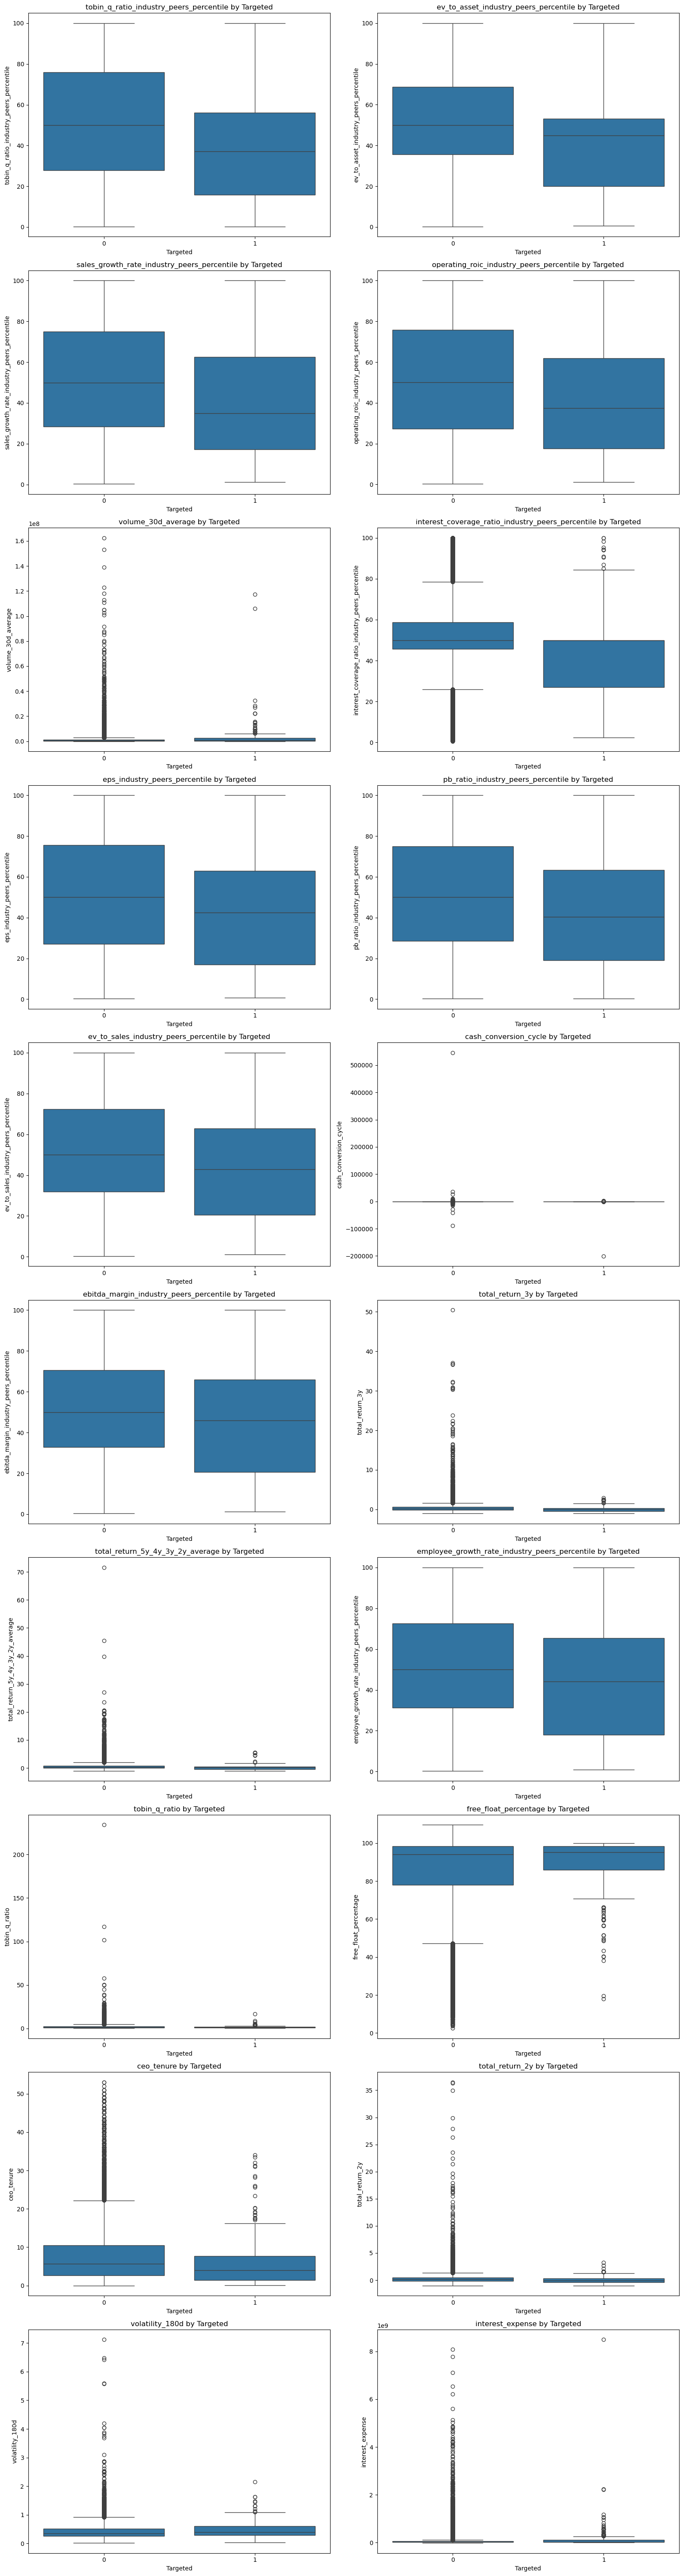

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Define features to plot
selected_features  = [
    'tobin_q_ratio_industry_peers_percentile',
    'ev_to_asset_industry_peers_percentile',
    'sales_growth_rate_industry_peers_percentile',
    'operating_roic_industry_peers_percentile',
    'volume_30d_average',
    'interest_coverage_ratio_industry_peers_percentile',
    'eps_industry_peers_percentile',
    'pb_ratio_industry_peers_percentile',
    'ev_to_sales_industry_peers_percentile',
    'cash_conversion_cycle',
    'ebitda_margin_industry_peers_percentile',
    'total_return_3y',
    'total_return_5y_4y_3y_2y_average',
    'employee_growth_rate_industry_peers_percentile',
    'tobin_q_ratio',
    'free_float_percentage',
    'ceo_tenure',
    'total_return_2y',
    'volatility_180d',
    'interest_expense'
]


cols_to_plot = [col for col in selected_features if col in df_labeled.columns]

# Layout: 2 plots per row
n_cols = 2
n_rows = math.ceil(len(cols_to_plot) / n_cols)

plt.figure(figsize=(8 * n_cols, 6 * n_rows))
for i, col in enumerate(cols_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(data=df_labeled, x='targeted', y=col)
    plt.title(f"{col} by Targeted")
    plt.xlabel("Targeted")
    plt.ylabel(col)

plt.tight_layout()
plt.show()


In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

# Define the top numeric features
features = selected_features 

# Extract features and label
X = df_labeled[features].copy()
y = df_labeled['targeted']

# Fill missing values with median
X = X.fillna(X.median())

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Output shapes and class balance
print("✅ Train set size:", X_train.shape)
print("✅ Test set size:", X_test.shape)
print("📊 Positive class ratio in train:", y_train.mean())


✅ Train set size: (15508, 20)
✅ Test set size: (6647, 20)
📊 Positive class ratio in train: 0.012058292494196543


In [12]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Slightly oversample to make positives = 5% of total training size
sm = SMOTE(sampling_strategy=0.05, random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# Check new class distribution
print("🔁 Resampled class distribution:", Counter(y_train_smote))

🔁 Resampled class distribution: Counter({0: 15321, 1: 766})


Classification Report:
               precision    recall  f1-score   support

           0      0.990     1.000     0.995      6567
           1      0.917     0.138     0.239        80

    accuracy                          0.989      6647
   macro avg      0.953     0.569     0.617      6647
weighted avg      0.989     0.989     0.986      6647

 Confusion Matrix:
 [[6566    1]
 [  69   11]]
 ROC AUC Score: 0.6866272651134461


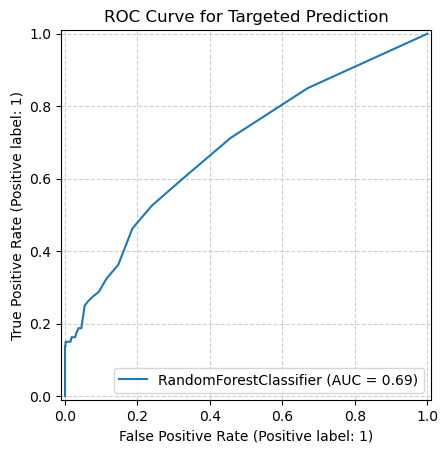

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Train model with class weights to help with imbalance
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
#clf.fit(X_train, y_train)
clf.fit(X_train_smote, y_train_smote)

# Predict
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(" ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Plot ROC curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve for Targeted Prediction")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Top Important Features (Random Forest):
                                              Feature  Importance
1               ev_to_asset_industry_peers_percentile    0.088478
15                              free_float_percentage    0.072169
4                                  volume_30d_average    0.068686
0             tobin_q_ratio_industry_peers_percentile    0.063857
2         sales_growth_rate_industry_peers_percentile    0.063152
18                                    volatility_180d    0.055672
3            operating_roic_industry_peers_percentile    0.051173
13     employee_growth_rate_industry_peers_percentile    0.048707
6                       eps_industry_peers_percentile    0.048514
19                                   interest_expense    0.046660
7                  pb_ratio_industry_peers_percentile    0.046504
14                                      tobin_q_ratio    0.046081
16                                         ceo_tenure    0.042100
11                                  

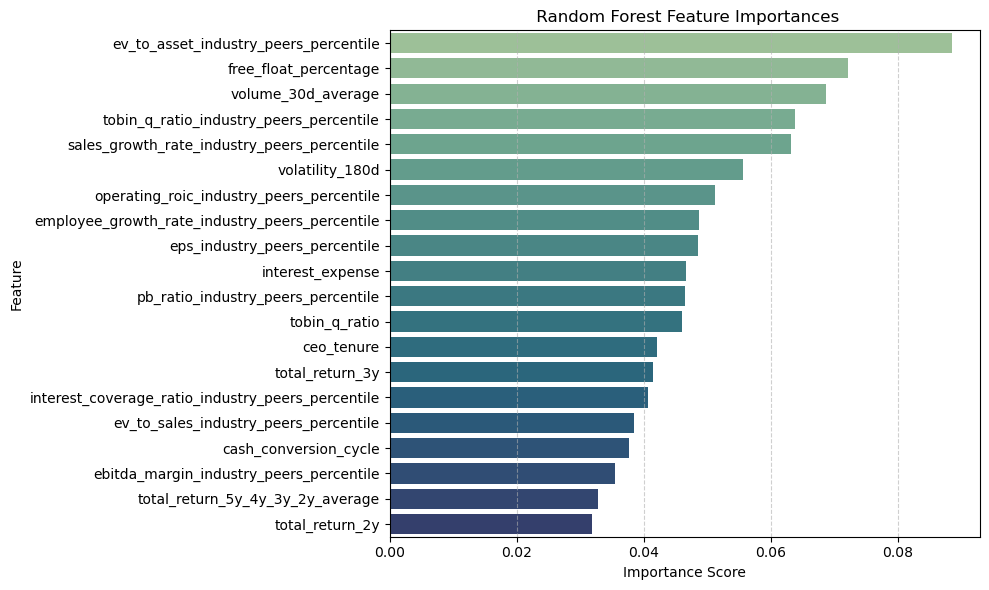

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
rf_importances = clf.feature_importances_
rf_feature_names = X_train.columns

# Create DataFrame for plotting
rf_df = pd.DataFrame({
    'Feature': rf_feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

print("Top Important Features (Random Forest):")
print(rf_df.head(20))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=rf_df, y='Feature', x='Importance', palette='crest')
plt.title(" Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


[LightGBM] [Info] Number of positive: 766, number of negative: 15321
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 16087, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
📊 Classification Report:
               precision    recall  f1-score   support

           0      0.990     0.992     0.991      6567
           1      0.172     0.138     0.153        80

    accuracy                          0.982      6647
   macro avg      0.581     0.565     0.572      6647
weighted avg      0.980     0.982     0.981      6647

📉 Confusion Matrix:
 [[6514   53]
 [  69   11]]
📈 ROC AUC Score: 0.6565174356631645


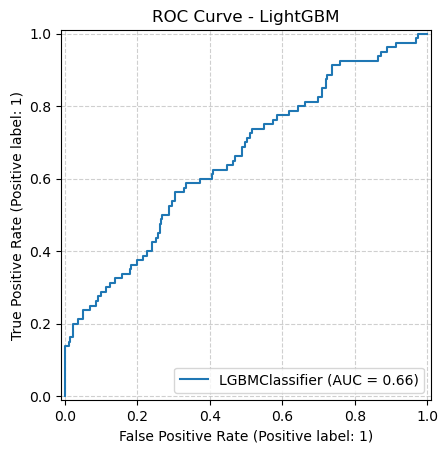

In [15]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Train LightGBM with class weighting
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42,
    class_weight='balanced'
)

lgbm.fit(X_train_smote, y_train_smote)

# Predict
y_proba = lgbm.predict_proba(X_test)[:, 1]
y_pred = (y_proba > 0.5).astype(int)  # You can lower this to 0.3 later

# Evaluate
print("📊 Classification Report:\n", classification_report(y_test, y_pred, digits=3))
print("📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("📈 ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Plot ROC
RocCurveDisplay.from_estimator(lgbm, X_test, y_test)
plt.title("ROC Curve - LightGBM")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


 Most Important Features (LightGBM):
                                              Feature  Importance
19                                   interest_expense        1245
4                                  volume_30d_average        1090
2         sales_growth_rate_industry_peers_percentile         942
15                              free_float_percentage         864
16                                         ceo_tenure         834
18                                    volatility_180d         800
13     employee_growth_rate_industry_peers_percentile         798
9                               cash_conversion_cycle         795
11                                    total_return_3y         742
14                                      tobin_q_ratio         737
17                                    total_return_2y         735
6                       eps_industry_peers_percentile         675
1               ev_to_asset_industry_peers_percentile         640
8               ev_to_sales_industry_pe

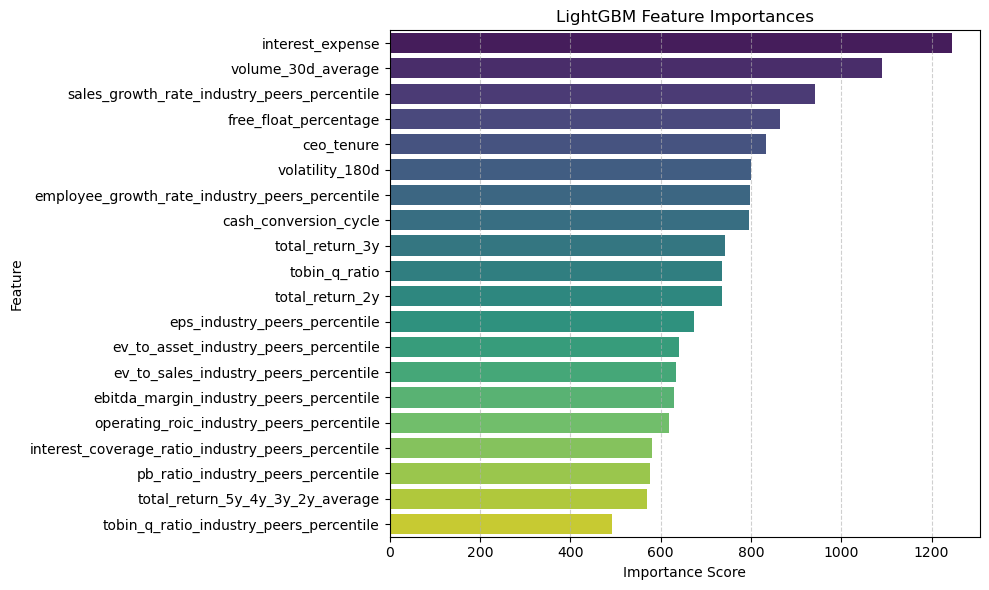

In [16]:
# Get feature importances
importances = lgbm.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easier plotting
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Optional: display top 10
print(" Most Important Features (LightGBM):")
print(fi_df.head(20))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=fi_df, y='Feature', x='Importance', palette='viridis')
plt.title("LightGBM Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [17]:
# Meta-Model
# Train base models
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
lgbm = LGBMClassifier(n_estimators=500, learning_rate=0.05, random_state=42, class_weight='balanced')

rf.fit(X_train_smote, y_train_smote)
lgbm.fit(X_train_smote, y_train_smote)


[LightGBM] [Info] Number of positive: 766, number of negative: 15321
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 16087, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=500,
               random_state=42)

In [18]:
# Get predicted probabilities from each base model
rf_proba_train = rf.predict_proba(X_train_smote)[:, 1]
lgbm_proba_train = lgbm.predict_proba(X_train_smote)[:, 1]

rf_proba_test = rf.predict_proba(X_test)[:, 1]
lgbm_proba_test = lgbm.predict_proba(X_test)[:, 1]

# Combine them into new features for the meta-model
import numpy as np

X_meta_train = np.column_stack((rf_proba_train, lgbm_proba_train))
X_meta_test = np.column_stack((rf_proba_test, lgbm_proba_test))


 Meta-Model Classification Report:
               precision    recall  f1-score   support

           0      0.990     0.998     0.994      6567
           1      0.440     0.138     0.210        80

    accuracy                          0.988      6647
   macro avg      0.715     0.568     0.602      6647
weighted avg      0.983     0.988     0.984      6647

 Confusion Matrix:
 [[6553   14]
 [  69   11]]
ROC AUC Score: 0.6751084970306076


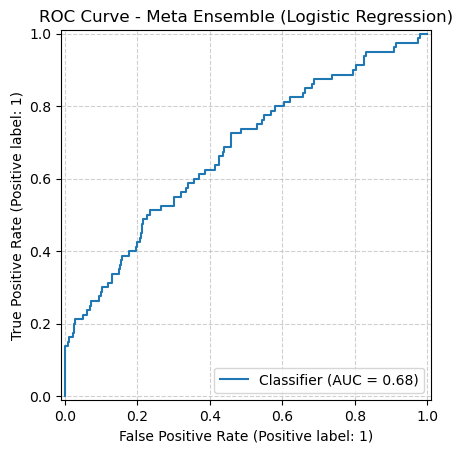

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Train meta model
meta_model = LogisticRegression()
meta_model.fit(X_meta_train, y_train_smote)

# Predict and evaluate
y_meta_proba = meta_model.predict_proba(X_meta_test)[:, 1]
y_meta_pred = (y_meta_proba > 0.5).astype(int)

# Report
print(" Meta-Model Classification Report:\n", classification_report(y_test, y_meta_pred, digits=3))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_meta_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_meta_proba))

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_meta_proba)
plt.title("ROC Curve - Meta Ensemble (Logistic Regression)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


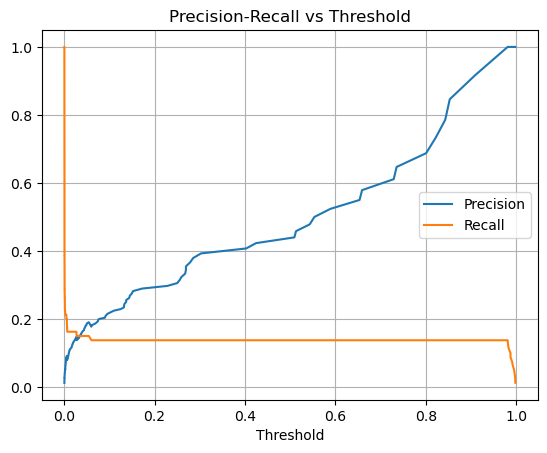

In [20]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresh = precision_recall_curve(y_test, y_meta_proba)

# Plot
plt.plot(thresh, prec[:-1], label='Precision')
plt.plot(thresh, rec[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.title('Precision-Recall vs Threshold')
plt.grid()
plt.show()
